In [401]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [402]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [403]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]

# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])

df.head()

C:\Users\shans\AppData\Local\Temp\ipykernel_27332\2678655226.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['state'].replace(['successful','failed'],[1,0])


,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1601563193,Our future,100000000.0,1.00,0,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,...,1,2014,21,8,8,2014,12,6,60,60
1,880009511,Elite: Dangerous,1250000.0,1578316.08,1,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,...,31,2012,11,11,5,2012,18,5,60,60
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",1000000.0,5408916.95,1,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,...,22,2014,22,5,28,2014,8,35,35,35
5,1966069095,ARKYD: A Space Telescope for Everyone,1000000.0,1505366.60,1,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,...,10,2012,17,5,29,2013,10,322,32,32
6,2083255961,A Billion Pixels...,100000000.0,56.00,0,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,...,1,2014,16,6,5,2014,16,34,60,60


# 1. Data Preprocessing

In [404]:
# Check the number of rows and columns 
df.shape

(13435, 45)

### 1.1 Detect Duplicated Records

In [405]:
# Check if there is any duplicated records
df = df.drop_duplicates()

### 1.2 Detect Missing Values

In [406]:
# Check if there is any missing values
missing_values = np.where(pd.isnull(df))

In [407]:
# Identify the columns that contain missing values
df.columns[list(set(np.where(pd.isnull(df))[1]))]

Index(['category', 'name'], dtype='object')

In [408]:
# Count the percentage of missing values
len(missing_values[0]) / df.shape[0]

0.09341272794938593

The predictors might be important for our future prediction.
And the number of records that contains missing values isn't significant in this dataset.
Hence we drop the missing values.

In [409]:
df = df.dropna()
df.shape

(12180, 45)

### 1.3 Drop out-of-scope predictors

According to the project instruction, we can only use the predictors "that are available at the moment when a new project is launched."
Therefore, we do not need any predictors regarding 'states' of the project.

In [410]:
df = df.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days'])

The information about pledged, staff_pick, backers_count, spotlight wont be available at the moment when the project is launched. Therefore, we remove them as well.

In [411]:
df = df.drop(columns = ['pledged','usd_pledged','staff_pick','backers_count','spotlight'])

### 1.4 Identify unique identifiers

In [412]:
# Number of unique values
df.nunique()

id                         12180
name                       12174
goal                         821
state                          2
disable_communication          1
country                       18
currency                      10
deadline                   12042
created_at                 12180
launched_at                12177
static_usd_rate             1824
category                      22
name_len                      16
name_len_clean                14
blurb_len                     32
blurb_len_clean               27
deadline_weekday               7
created_at_weekday             7
launched_at_weekday            7
deadline_month                12
deadline_day                  31
deadline_yr                    8
deadline_hr                   24
created_at_month              12
created_at_day                31
created_at_yr                  8
created_at_hr                 24
launched_at_month             12
launched_at_day               31
launched_at_yr                 8
launched_a

In [413]:
# Note that disable_communication only have one unique value
# So it won't be useful for our prediction
df = df.drop(columns = ['disable_communication'])

# we can drop [id, name, deadline, created_at, launched_at] as they are almost a unique identifier
df= df.drop(columns = ['id','name','deadline', 'created_at', 'launched_at'])

### 1.5 Detect collinearity between variables

C:\Users\shans\AppData\Local\Temp\ipykernel_27332\3496678569.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


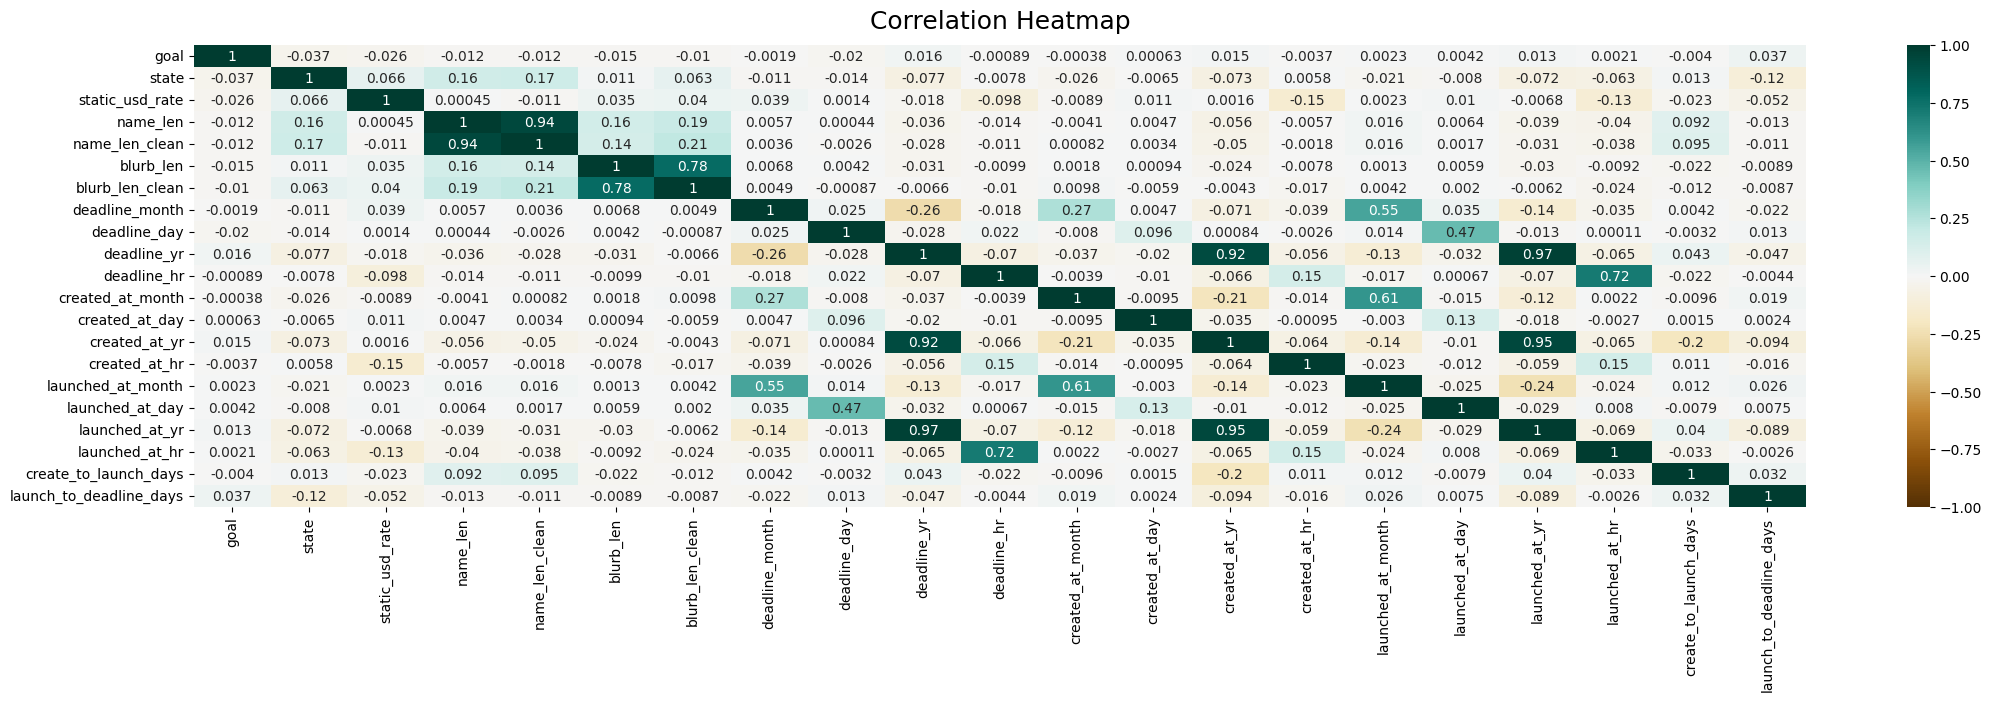

In [414]:
# check if there is any collinearity between variables
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap_classification.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation:
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,
- deadline_yr and created_at_yr and launched_at_yr

For each pair, we only need to keep one of them.

In [415]:
df = df.drop(columns = ['name_len_clean','blurb_len_clean','created_at_yr', 'launched_at_yr'])

### 1.6 Handle Categorical Variables

In [416]:
# Check variable types
df.dtypes

goal                       float64
state                        int64
country                     object
currency                    object
static_usd_rate            float64
category                    object
name_len                   float64
blurb_len                  float64
deadline_weekday            object
created_at_weekday          object
launched_at_weekday         object
deadline_month               int64
deadline_day                 int64
deadline_yr                  int64
deadline_hr                  int64
created_at_month             int64
created_at_day               int64
created_at_hr                int64
launched_at_month            int64
launched_at_day              int64
launched_at_hr               int64
create_to_launch_days        int64
launch_to_deadline_days      int64
dtype: object

In [417]:
# For 'weekday' variables. convert them into numerical variable from 1-7
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df[cols] = df[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [418]:
df = pd.get_dummies(df, columns = ['country','currency','category'])
df.head()

,goal,state,static_usd_rate,name_len,blurb_len,deadline_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,...,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries
4,1000000.0,1,1.0,8.0,22.0,3,2,3,7,2,...,0,0,0,0,0,0,0,0,1,0
6,100000000.0,0,1.0,3.0,17.0,1,4,4,8,4,...,0,0,0,0,0,0,0,0,1,0
7,800000.0,1,1.0,8.0,15.0,2,2,2,4,15,...,0,0,0,0,1,0,0,0,0,0
8,750000.0,1,1.0,5.0,10.0,6,2,4,10,27,...,0,0,0,0,0,0,0,0,0,0
11,55000000.0,0,1.0,6.0,8.0,2,3,5,9,1,...,0,0,0,1,0,0,0,0,0,0


## 2. Feature Selection

In [419]:
X = df.loc[:,df.columns != 'state']
y = df['state']

# Standardize the predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### 2.1 Using LASSO

In [420]:
# Run LASSO
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_std_lasso,y)

model_lasso.coef_

test = pd.DataFrame(list(zip(X.columns,model_lasso.coef_)), columns = ['predictor','coefficient'])
test[abs(test['coefficient']) >= 0.01].sort_values(by = 'coefficient')

,predictor,coefficient
67,category_Web,-0.085014
62,category_Software,-0.066146
18,launch_to_deadline_days,-0.031100
9,deadline_yr,-0.030876
58,category_Places,-0.018529
16,launched_at_hr,-0.013986
55,category_Immersive,0.014350
50,category_Experimental,0.021910
61,category_Shorts,0.022990
57,category_Musical,0.030356


### 2.2 Using Random Forest

C:\Users\shans\AppData\Local\Temp\ipykernel_27332\4153565337.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])


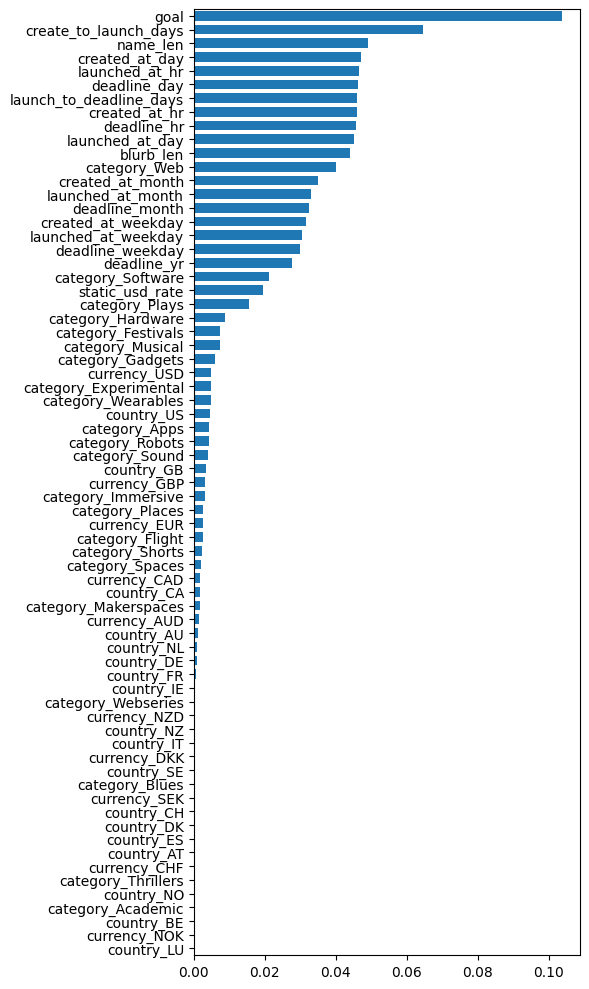

<Figure size 640x480 with 0 Axes>

In [421]:
# Feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(random_state=0)
model = rf.fit(X_std, y)

result = permutation_importance(rf, X_std, y, n_repeats=1,
                                random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 10))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf.feature_importances_)))

fig.tight_layout()
plt.show()
plt.savefig('RandomForest_FeatureImportance.png', dpi=300, bbox_inches='tight')

# Print feature importance
#pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False).plot(kind = 'bar',figsize = (14,6))

### 2.3 Recursive Feature Elimination

In [422]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=10) 
model = rfe.fit(X,y)

# Running logistics regression with different combination of predictors
model.support_
temp = pd.DataFrame(list(zip(X.columns,model.ranking_)), 
             columns = ['predictor','ranking'])

temp[temp['ranking']==1]

,predictor,ranking
26,country_ES,1
30,country_IT,1
47,category_Academic,1
49,category_Blues,1
58,category_Places,1
61,category_Shorts,1
62,category_Software,1
65,category_Thrillers,1
67,category_Web,1
68,category_Webseries,1


# 3. Classification Models

In [476]:
X = df[['goal', 'create_to_launch_days', 'name_len', 'created_at_day', 'launched_at_hr']]
  #      'deadline_day', 'launch_to_deadline_days','created_at_hr','deadline_hr','launched_at_day', 
   #     'blurb_len', 'category_Web', 'created_at_month','launched_at_month', 'deadline_month',
    #    'created_at_weekday','launched_at_weekday','deadline_weekday', 'deadline_yr', 'category_Software',
     #   'static_usd_rate', 'category_Plays','category_Hardware','category_Festivals','category_Musical']]

#X = df.loc[:,df.columns != 'state']
y = df["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.33, random_state = 5)

In [425]:
### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pca.fit(X_std)
X_new = pca.transform(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.30, random_state=5)

### 3.1 Logistic Regression

In [477]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 500)
model_logit = lr.fit(X_train, y_train)

### 3.2 DecisionTree

In [478]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(max_depth=10) # default is to grow a full tree
                                    # avoid overfitting
model_dt = decisiontree.fit(X_train,y_train)

### 3.3 Random Forest

In [488]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True, max_depth= 5)
model_rf = rf.fit(X_train, y_train)
#model_rf = rf.fit(X,y)

model_rf.oob_score_

0.6971813725490196

### 3.4 Gradient Boosting

In [480]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(random_state = 0)
model_gbt = gbt.fit(X_train, y_train)
#model_gbt = gbt.fit(X, y)

### 3.5 K-Nearest Neighbors

In [481]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

accuracy = 0
bestK = 0
for i in range (1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    if accuracy_score(y_test, y_test_pred) > accuracy:
        accuracy = accuracy_score(y_test, y_test_pred)
        bestK = i
    #print("k = ", i, "accuracy =", accuracy_score(y_test, y_test_pred))

knn = KNeighborsClassifier(n_neighbors=bestK) #,  weights = 'distance')
model_knn = knn.fit(X_train, y_train)

### 3.6 Artificial Neural Network

In [431]:
# Find the optimal size of hidden layer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
for i in range(1,21): 
    model = MLPClassifier(hidden_layer_sizes=(i), max_iter = 1000, random_state=0)
    scores = cross_val_score(model, X=X_std, y=y, cv=10)
    print(i, ":", np.average(scores))

1 : 0.6869458128078818


C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


2 : 0.6891625615763547


C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


3 : 0.6970443349753694
4 : 0.6954022988505747
5 : 0.693103448275862
6 : 0.6951559934318555
7 : 0.6889162561576354
8 : 0.6955665024630543
9 : 0.6939244663382593
10 : 0.6904761904761905
11 : 0.6862889983579639
12 : 0.6932676518883415
13 : 0.6875205254515598
14 : 0.6929392446633826
15 : 0.6926108374384237
16 : 0.6856321839080459
17 : 0.6910509031198686
18 : 0.6935960591133006
19 : 0.6936781609195403
20 : 0.6923645320197045


In [482]:
from sklearn.neural_network import MLPClassifier
model_ann = MLPClassifier(hidden_layer_sizes=(3), random_state=0)
model_mlp = model_ann.fit(X_train,y_train)

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
## Find the best hyper-parameter
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=5000, random_state=0)

parameter = {'hidden_layer_sizes': range(1,22)}
grid_search = GridSearchCV(estimator = mlp, param_grid= parameter, 
                           scoring = "accuracy", verbose=True)
model_mlp = grid_search.fit(X_std, y)

### 3.7 Support Vector Machine

In [ ]:
# Find the optimal gamma
from sklearn.svm import SVC
for i in range(1,11):
    svm_rbf = SVC(kernel = "rbf", random_state=0, C =0.5, gamma = i)
    model_rbf = svm_rbf.fit(X_train,y_train)
    scores = cross_val_score(model_rbf,X=X_test, y=y_test, cv=10)
    print("gamma = ",i,", score = ", sum(scores)/len(scores))

In [483]:
# Build the SVM model using a linear model
from sklearn.svm import SVC
svm = SVC(kernel="linear", random_state=0, C=0.5, gamma = 3)
model_svm = svm.fit(X_train, y_train)

### Model Performance Comparison

In [451]:
from sklearn import metrics

def model_metrics(model,X,y):
    y_pred = model.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)

    model_metrics = [accuracy, precision, recall, f1_score]
    return model_metrics

In [484]:
model_performance = {
    'Logitstic': model_metrics(model_logit,X_test,y_test),
    'KNN': model_metrics(model_knn,X_test,y_test),

    'DecisionTree': model_metrics(model_dt,X_test,y_test),
    'RandomForest': model_metrics(model_rf,X_test,y_test),
    'GradientBoosting': model_metrics(model_gbt,X_test,y_test),

    'ANN': model_metrics(model_ann,X_test,y_test),
    'SVM': model_metrics(model_svm,X_test,y_test)    
}

pd.DataFrame.from_dict(model_performance, orient='index',columns = ['accuracy','percision','recall','f1_score'])

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,percision,recall,f1_score
Logitstic,0.673632,0.494898,0.074046,0.128818
KNN,0.664428,0.433898,0.097710,0.159502
DecisionTree,0.669154,0.489837,0.367939,0.420227
RandomForest,0.676617,0.505556,0.347328,0.411765
GradientBoosting,0.694030,0.551546,0.326718,0.410355
ANN,0.671144,0.453846,0.045038,0.081944
SVM,0.674129,0.000000,0.000000,0.000000


### K-Fold CV on potential classifiers

In [490]:
from sklearn.model_selection import cross_val_score

scores_log = cross_val_score(model_logit, X=X_std, y=y, cv=5)
scores_rf = cross_val_score(model_rf, X=X_std, y=y, cv=5)
scores_gbt = cross_val_score(model_gbt, X=X_std, y=y, cv=5)
scores_ann = cross_val_score(model_ann, X=X_std, y=y, cv=5)
scores_svm = cross_val_score(model_svm, X=X_std, y=y, cv=5)

print(scores_log, scores_rf,scores_gbt,scores_ann, scores_svm, sep='\n')

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shans\A

[0.67446634 0.68801314 0.67610837 0.65640394 0.66707718]
[0.67405583 0.67405583 0.67487685 0.67487685 0.67487685 0.46962233
 0.27339901 0.06075534 0.01313629 0.32512315]
[0.67446634 0.08866995 0.13136289 0.07183908 0.32512315]
[0.67405583 0.68596059 0.67651888 0.6592775  0.66584565]
[0.67446634 0.67446634 0.67487685 0.67487685 0.67487685]


### Lazy Classifier

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

# 4. Evaluation on Grading Dataset

In [447]:
# Loading libraries
import pandas as pd
import numpy as np

# Import the dataset
grading = pd.read_excel('Kickstarter-Grading-Sample.xlsx')

# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df_test = grading[grading['state'].isin(['successful','failed'])]
df_test['state'] = df_test['state'].replace(['successful','failed'],[1,0])

# Data Preprocessing
df_test = df_test.dropna()

### Drop out-of-scope predictors
df_test = df_test.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 
'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days',
'pledged','staff_pick','backers_count','spotlight','disable_communication',
'id','name','deadline', 'created_at', 'launched_at','usd_pledged','name_len_clean','created_at_yr', 'launched_at_yr'])

### Handle Categorical Variables
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df_test[cols] = df_test[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

# dummify the other categorical variables
df_test = pd.get_dummies(df_test, columns = ['country','currency','category'])

# Testing
#X_grade = df_test[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
#'category_Web','category_Software','category_Plays','category_Festivals']]

#X_grade = df_test[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
#'launched_at_hr','launched_at_day','created_at_day','created_at_hr','deadline_day','blurb_len',
# 'category_Web','created_at_month','deadline_month','created_at_weekday','launched_at_weekday','deadline_yr',
# 'category_Software','static_usd_rate','category_Plays','category_Festivals','category_Hardware','category_Musical']]

X_grade = df_test[['goal', 'create_to_launch_days', 'name_len', 'created_at_day', 'launched_at_hr',
        'deadline_day', 'launch_to_deadline_days','created_at_hr','deadline_hr','launched_at_day', 
        'blurb_len', 'category_Web', 'created_at_month','launched_at_month', 'deadline_month', 
        'created_at_weekday','launched_at_weekday','deadline_weekday', 'deadline_yr', 'category_Software',
        'static_usd_rate', 'category_Plays','category_Hardware','category_Festivals','category_Musical']]

# X_grade = df_test.loc[:,df.columns != 'state']
y_grade = df_test["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_grade = scaler.fit_transform(X_grade)


### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_std)
#X_grade = pca.transform(X_grade)

C:\Users\shans\AppData\Local\Temp\ipykernel_27332\1264865177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['state'] = df_test['state'].replace(['successful','failed'],[1,0])


PCA(n_components=3)

In [448]:
test_performance = {
    'Logitstic': model_metrics(model_logit,X_grade,y_grade),
    'KNN': model_metrics(model_knn,X_grade,y_grade),

    'DecisionTree': model_metrics(model_dt,X_grade,y_grade),
    'RandomForest': model_metrics(model_rf,X_grade,y_grade),
    'GradientBoosting': model_metrics(model_gbt,X_grade,y_grade),

    'ANN': model_metrics(model_ann,X_grade,y_grade),
    'SVM': model_metrics(model_svm,X_grade,y_grade)
}

pd.DataFrame.from_dict(test_performance, orient='index',columns = ['accuracy','percision','recall','f1_score'])

,accuracy,percision,recall,f1_score
Logitstic,0.737736,0.623800,0.595238,0.609185
KNN,0.730189,0.670554,0.421245,0.517435
DecisionTree,0.573585,0.423434,0.668498,0.518466
RandomForest,0.681132,0.526459,0.710623,0.604832
GradientBoosting,0.571069,0.435361,0.838828,0.573217
ANN,0.726415,0.607767,0.573260,0.590009
SVM,0.723899,0.670927,0.384615,0.488941
